# EE-411 Fundamentals of inference and learning

## Exercise session 13: Autoencoder, denoising and K-means

In the first part of this set of exercises we will write an Auto-encoder in Python using Keras, and we will apply it for a denoising problem, evaluating its performance in different situations. In the second part we will have a simple implementation of the K-means method for clustering using scikit-learn.

**What you will learn today:** In this notebook, we will use an alternative to Pytorch: Keras. Specifically, we will use it to implement an Autoencoder. Then, we will see how to do clustering with K-means using scikit-learn.


# 1) Autoencoder

An autoencoder, autoassociator or Diabolo network is an artificial neural network whose aim is to learn a representation (or an *encoding*) for a set of data, often for the purpose of dimensionality reduction. Recently, the autoencoder concept has become more widely used for denoising images, and we shall illustrate these in this notebook on the MNIST dataset. 

First, let us look download the images from the MNIST dataset, and look at some of them.

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


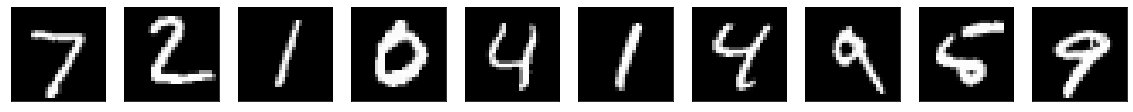

In [1]:
from keras.datasets import mnist
import numpy as np
#We load the data
(x_train, _), (x_test, _) = mnist.load_data()
#We renormalize the data to a float in [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#We reshape the images to be 2d matrices of dimension n times d
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)
#We plot the first ten images
%matplotlib inline
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Let us define our autoencoder using Keras. If you already know how to work with Pytorch, this will be very intuitive. 

**First** we encode data by a first neural network that goes from the $784$ points to $128$, then $64$ and finally $32$. 

**Second** we write the decoder that performs the same operation, in reverse.

**Third** we can build our model and compile it,

In [2]:
from keras.layers import Input, Dense
from keras.models import Model
input_img = Input(shape=(784,))
#Encoding
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
#Decoding
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
#Putting all together
autoencoder_mlp = Model(input_img, decoded)
autoencoder_mlp.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_mlp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

We now run the training for $100$ epochs. This takes some time because there are a lot of paramteres to learn. On a K80 GPU it takes 1sec/epoch, but on a standard CPU it is about 6sec/epoch.

In [3]:
#Training the model -- CAN BE SKIPPED TO SAVE TIME
history_mlp = autoencoder_mlp.fit(x_train, x_train,
                epochs=500,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/500
235/235 [==============================] - 4s 7ms/step - loss: 0.2504 - val_loss: 0.1689
Epoch 2/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1534 - val_loss: 0.1405
Epoch 3/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1349 - val_loss: 0.1267
Epoch 4/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1241 - val_loss: 0.1189
Epoch 5/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1178 - val_loss: 0.1140
Epoch 6/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1136 - val_loss: 0.1104
Epoch 7/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1100 - val_loss: 0.1068
Epoch 8/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1071 - val_loss: 0.1047
Epoch 9/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1048 - val_loss: 0.1024
Epoch 10/500
235/235 [==============================] - 1s 6ms/step - loss: 0.1029 - val_lo

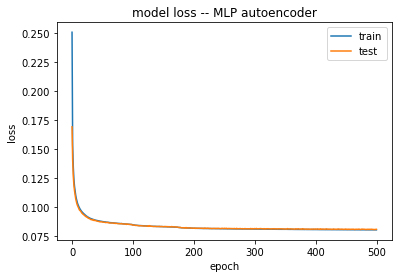

In [4]:
# Plot history for accuracy
plt.plot(history_mlp.history['loss'])
plt.plot(history_mlp.history['val_loss'])
plt.title('model loss -- MLP autoencoder')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
# READ THE WEIGHTS FROM FILE
#autoencoder_mlp.save_weights("dense_autoencoder.h5")
autoencoder_mlp.load_weights("dense_autoencoder.h5")

Now, it is time to see the result of the learning process. 

Let us create an "encoder" model with the weights that we have learned, that outputs the result of the middle layer, and records the images corresponding to the test set observed after compression:

In [14]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
print(encoded_imgs.shape)

(10000, 32)


We now do the same, but for the full autoencoder:

In [15]:
decoded_imgs = autoencoder_mlp.predict(x_test)
print(decoded_imgs.shape)

(10000, 784)


Let us see how it looks:

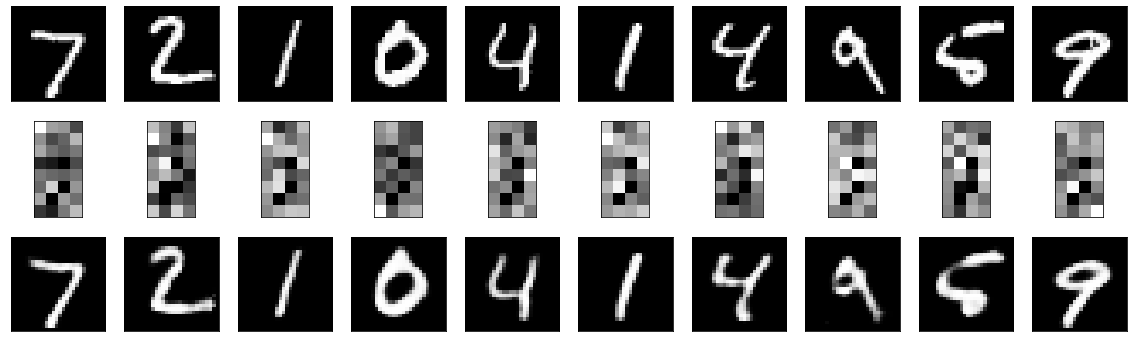

In [16]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n + n )
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [17]:
len(encoded_imgs)

10000

This is quite nice, and indeed we see that we can recognize images quite easily. We can also have a look at the 32-dimensional encoded representations in the middle. Notice how the two "one" are coded similarly, as well as the two "four".

### Convolutional auto-encoder

Now we are going to build the autoencoer only with cnn:

In [5]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# After the encoding, the representation is (4, 4, 8) (128-dimensional)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder_cnn = Model(input_img, decoded)
autoencoder_cnn.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_cnn.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584 

Since we are using cnn layers, images should be kept as two-dimensional arrays. Once this is done, we repeat the fitting operation. It takes about 5s by epoch on a K80 GPU.

In [6]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [21]:
#Training the model -- CAN BE SKIPPED TO SAVE TIME
history_cnn = autoencoder_cnn.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/200
469/469 [==============================] - 7s 13ms/step - loss: 0.2086 - val_loss: 0.1406
Epoch 2/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1319 - val_loss: 0.1244
Epoch 3/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1212 - val_loss: 0.1170
Epoch 4/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1154 - val_loss: 0.1119
Epoch 5/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1114 - val_loss: 0.1090
Epoch 6/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1085 - val_loss: 0.1062
Epoch 7/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1062 - val_loss: 0.1048
Epoch 8/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1045 - val_loss: 0.1025
Epoch 9/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1031 - val_loss: 0.1014
Epoch 10/200
469/469 [==============================] - 6s 12ms/step - loss: 0.101

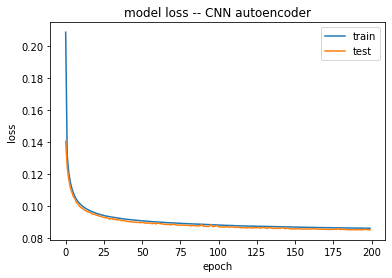

In [22]:
# Plot history for accuracy
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('model loss -- CNN autoencoder')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [23]:
# READ WEIGHTS FROM FILE
#autoencoder_cnn.save_weights("cnn_autoencoder.h5")
autoencoder_cnn.load_weights("cnn_autoencoder.h5")

Let us again look at the results:

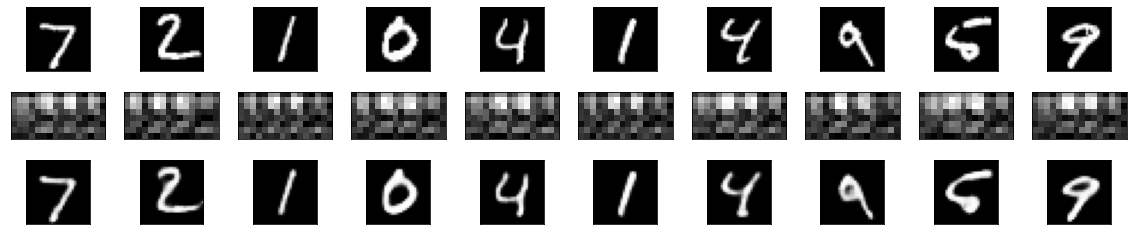

In [24]:
encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder_cnn.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display original
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(16, 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising with auto-encoders

### Noisy images

Now, we shall use our auto-encoders for denoising. We will train the autoencoder to map noisy images to clean ones. This will be done by applying a gaussian noise (and clip the images between 0 and 1) to the training set.

In [7]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(60000, 784)
(10000, 784)


Let us see how these looks:

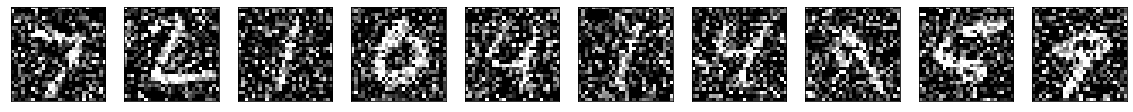

In [8]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Dense denoiser

Let's start by using the simple dense network we used above.

In [9]:
from keras.layers import Input, Dense
from keras.models import Model
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

denoiser_mlp = Model(input_img, decoded)
denoiser_mlp.compile(optimizer='adam', loss='binary_crossentropy')
denoiser_mlp.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 784)               1011

In [31]:
#Training the model -- CAN BE SKIPPED TO SAVE TIME
history_den_mlp = denoiser_mlp.fit(x_train_noisy, x_train,
                epochs=200,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/200
235/235 [==============================] - 2s 7ms/step - loss: 0.2604 - val_loss: 0.2058
Epoch 2/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1845 - val_loss: 0.1700
Epoch 3/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1647 - val_loss: 0.1583
Epoch 4/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1554 - val_loss: 0.1505
Epoch 5/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1487 - val_loss: 0.1453
Epoch 6/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1438 - val_loss: 0.1415
Epoch 7/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1400 - val_loss: 0.1379
Epoch 8/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1375 - val_loss: 0.1359
Epoch 9/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1356 - val_loss: 0.1345
Epoch 10/200
235/235 [==============================] - 1s 6ms/step - loss: 0.1340 - val_lo

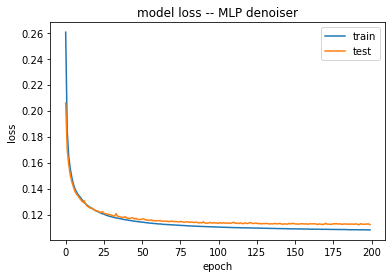

In [32]:
# Plot history for accuracy
plt.plot(history_den_mlp.history['loss'])
plt.plot(history_den_mlp.history['val_loss'])
plt.title('model loss -- MLP denoiser')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [35]:
# READ WEIGHTS FROM FILE
#enoiser_mlp.save_weights("dense_denoiser.h5")
denoiser_mlp.load_weights("dense_denoiser.h5")

Finally, we can look at the denoising performed on the noisy version of the test set. They are not so bad!

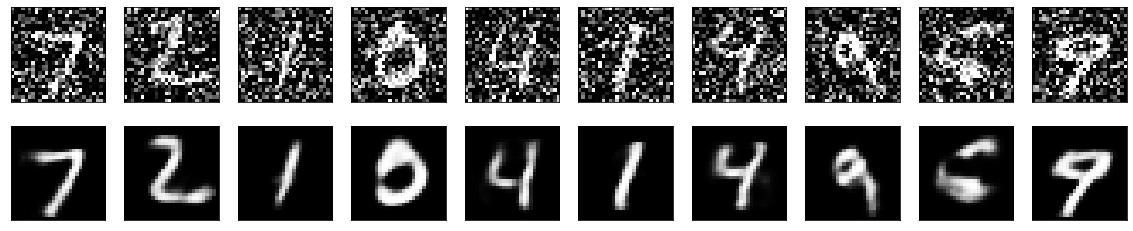

In [36]:
decoded_imgs = denoiser_mlp.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### CNN denoiser

In order to improve the quality of the reconstruction, we shall use a CNN with more filters per layer...

In [10]:
# Reshape the images to use a CNN
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  
x_train_noisy = np.reshape(x_train_noisy, (len(x_train_noisy), 28, 28, 1))  
x_test_noisy = np.reshape(x_test_noisy, (len(x_test_noisy), 28, 28, 1))  

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Here this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

denoiser_cnn = Model(input_img, decoded)
denoiser_cnn.compile(optimizer='adam', loss='binary_crossentropy')
denoiser_cnn.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 32)          9248

... and train it a bit longer (8sec/epoch on a GPU).

In [11]:
history_den_cnn = denoiser_cnn.fit(x_train_noisy, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/200
469/469 [==============================] - 16s 16ms/step - loss: 0.1623 - val_loss: 0.1157
Epoch 2/200
469/469 [==============================] - 7s 15ms/step - loss: 0.1122 - val_loss: 0.1076
Epoch 3/200
469/469 [==============================] - 7s 15ms/step - loss: 0.1070 - val_loss: 0.1049
Epoch 4/200
469/469 [==============================] - 7s 15ms/step - loss: 0.1042 - val_loss: 0.1021
Epoch 5/200
469/469 [==============================] - 7s 15ms/step - loss: 0.1023 - val_loss: 0.1007
Epoch 6/200
469/469 [==============================] - 7s 15ms/step - loss: 0.1009 - val_loss: 0.0997
Epoch 7/200
469/469 [==============================] - 7s 15ms/step - loss: 0.0999 - val_loss: 0.0995
Epoch 8/200
469/469 [==============================] - 7s 15ms/step - loss: 0.0990 - val_loss: 0.0981
Epoch 9/200
469/469 [==============================] - 7s 15ms/step - loss: 0.0984 - val_loss: 0.0976
Epoch 10/200
469/469 [==============================] - 7s 14ms/step - loss: 0.09

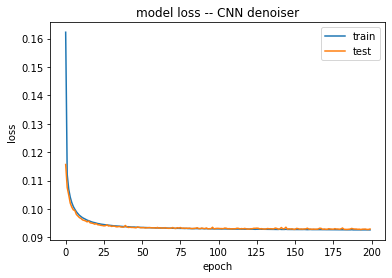

In [12]:
# Plot history for accuracy
plt.plot(history_den_cnn.history['loss'])
plt.plot(history_den_cnn.history['val_loss'])
plt.title('model loss -- CNN denoiser')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
#denoiser_cnn.save_weights("cnn_denoiser.h5")
denoiser_cnn.load_weights("cnn_denoiser.h5")

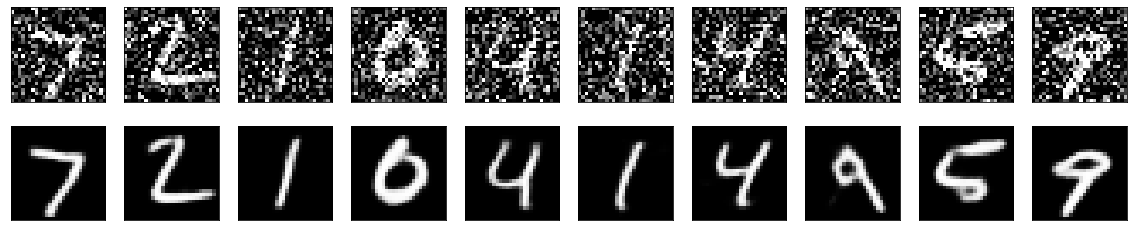

In [14]:
decoded_imgs = denoiser_cnn.predict(x_test_noisy)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# 2) K-means

Now we come back to scikit-learn to see how to easily implement K-means 

*1. Generate K Gaussian clusters of $n$ samples. Each cluster has $n_k = n/K$ data points $\boldsymbol{x}^{\mu}_{i,k} \in \mathbb{R}^{d}$ of mean  $\mu_k \in \mathbb{R}^{d}$, and covariance matrix  $\Sigma = \sigma \mathbb{I}_{d\times d}$. Take $d = 2$. Plot the data points in the 2-dimensional space with their centroids and assign to each data point a color according to cluster membership.*


Hint: for example, you can choose $n_k=100$, $K=3$ and $\sigma=1$. Try fixing some well-distanced centroids for this first part.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random

In [ ]:
def get_data(m, sigma, nk, d, K):
  """
  This function generates Gaussian clusters.
  Input:  m = center coordinate of each cluster;
          sigma = variance of each cluster;
          n = number of samples in each cluster;
          d = input dimension;
          K = number of clusters.
  Output: X = data organized in K clusters

  """
  X = np.concatenate([np.random.normal(m[k], sigma, size = (nk, d)) for k in range(K)]) # generate K cluster distributed according to the Gaussian distribution
  np.random.shuffle(X) # shuffle the dataset
  return X

In [ ]:
nk = 100
d = 2
K = 3
sigma = 1
m = [[0., 0.], [-5., -10.], [-8., 3.]]

X = get_data(m, sigma, nk, d, K) # build the data

In [ ]:
def distance_from_the_center(X, m):
  """
  This function assign to each example in X a label according to its distance from the center.
  Input:  X = data;
          m = centroids.
  Output: cluster_membership = array of length #of samples, containing the label reffering to the cluster to which examples in X belongs to;
          cost = sum of the square distances of each data point from its cluster 
  """

  cluster_membership = np.zeros(len(X)) # initialize an empty array of length = number of samples
  cost = 0. # initialize the cost function
  for mu in range(len(X)): # loop over all examples
    distances = np.zeros(K) # initialize an empty array of length = input dimension where to store all the distances a given example has from each centroid
    for k in range(K): # loop over all the clusters
      dist = np.linalg.norm(X[mu] - m[k]) # compute the square distance of an example mu from centroid k 
      distances[k] = dist # store the corresponding result in the array of distances
    cluster_membership[mu] = np.argmin(distances) # assign to the example a label referring to the closest cluster 
    cost += np.min(distances**2) # compute the cost function
  return cluster_membership, cost 

In [ ]:
cluster_membership, cost = distance_from_the_center(X, m) # extract the label of each example according to the cluster to which it belongs

In [ ]:
def plot_clusters_and_centroids(X, m, cluster_membership):
  """
  This function plots each cluster and its corresponding centroid.
  Input: X = data points;
         m =  centroids;
         cluster_membership = array of length #of samples, containing the label reffering to the cluster to which examples in X belongs to. 
  Output: plot of the clusters and their centroids.
  """
  plt.scatter(X[:,0], X[:,1], c = cluster_membership, cmap=matplotlib.colors.ListedColormap(["green", "red", "lightblue"])) # plot the data points
  plt.scatter(m[0][0], m[0][1], c = 'black', marker = 'o') # plot the centroids
  plt.scatter(m[1][0], m[1][1], c = 'black', marker = 'o')
  plt.scatter(m[2][0], m[2][1], c = 'black', marker = 'o')
  plt.show()
  return

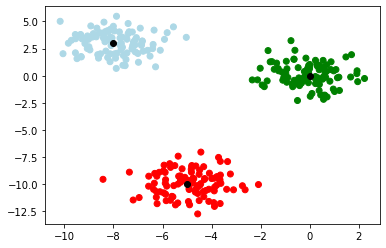

In [ ]:
plot_clusters_and_centroids(X, m, cluster_membership)

*2. Implement K-Means using the built-in methods from scikit-learn. You can use [this website](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) as a reference (by now you should be able to use scikit learn confidently). Plot the data points in the 2-dimensional space with their centroids and compare these to the predicted ones.*

Hint: You can use *Kmeans.cluster_centers_* and *Kmeans.labels_* to extract the means and the variances resepectively

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# run K-Means from scikit-learn

Kmeans = KMeans(n_clusters=3, init='k-means++') # initialize Kmeans
Kmeans.fit(X) # fit the data with K-Means

KMeans(n_clusters=3)

In [ ]:
centroids = Kmeans.cluster_centers_ # extract the mean
cluster_membership = Kmeans.labels_ # extract the variances

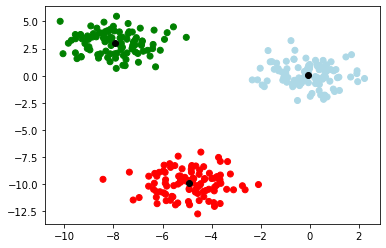

In [ ]:
plot_clusters_and_centroids(X, centroids, cluster_membership)

*3. Vary the variance $\sigma$ of each cluster and plot the detected cluster again with their centroids and colors assigned according to cluster membership. In which way are the predictions affected when the noise level is higher?*

sigma =  0.1


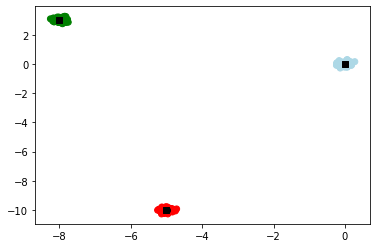

sigma =  0.5


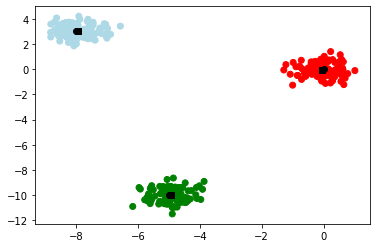

sigma =  1.0


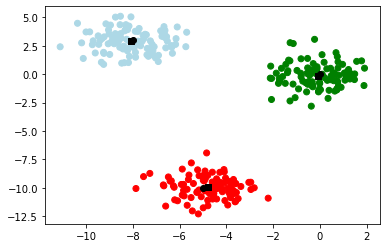

sigma =  5.0


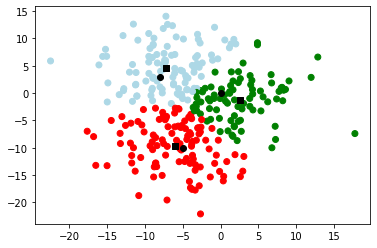

sigma =  10.0


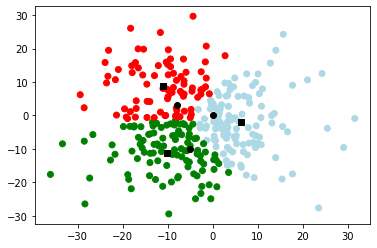

sigma =  100.0


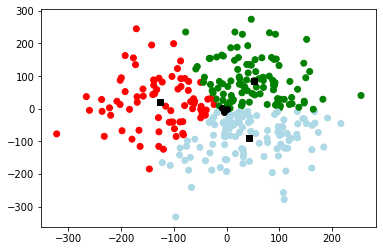

In [ ]:
sigmas = [0.1, 0.5, 1., 5., 10., 100.]

for sigma in sigmas:
  print("sigma = ", sigma)
  X = get_data(m, sigma, nk, d, K) # get the data
  Kmean = KMeans(n_clusters=3, init='k-means++') # run K-Means
  Kmean.fit(X)
  centroids = Kmean.cluster_centers_ # extract the means and the labels
  cluster_membership = Kmean.labels_
  plt.scatter(X[:,0], X[:,1], c = cluster_membership, cmap=matplotlib.colors.ListedColormap(["green", "red", "lightblue"])) # plot how the cluster prediction evolves according to noise
  plt.scatter(centroids[0][0], centroids[0][1], c = 'black', marker = 's') 
  plt.scatter(centroids[1][0], centroids[1][1], c = 'black', marker = 's')
  plt.scatter(centroids[2][0], centroids[2][1], c = 'black', marker = 's')
  plt.scatter(m[0][0], m[0][1], c = 'black', marker = 'o') 
  plt.scatter(m[1][0], m[1][1], c = 'black', marker = 'o')
  plt.scatter(m[2][0], m[2][1], c = 'black', marker = 'o')
  plt.show()

